## Курсовой проект   
## Real estate price prediction (Moscow)

План работы

  
    0. Импорты, загрузка данных, получение базового решения  
    1. Приведение типов, EDA  
    2. Обработка данных  
    3. Генерация новых фичей 
    4. Разбиение на train и test. Итоговая подготовка данных 
    5. Построение моделей 
    6. Прогнозирование на тестовом датасете   

### 0. Импорты, загрузка данных, получение базового решения

*По-быстрому получу хоть какое-то решение, посчитаю метрики. Потом можно будет отталкиваться от этих цифр. А если что-то пойдет не так, использую это решение как окончательное.*

###### Импорты

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.decomposition import PCA

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

###### Настройка среды

In [2]:
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})
%matplotlib inline

###### Пути к директориям и файлам

In [3]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

###### Описание датасета

Id - идентификационный номер квартиры  
DistrictId - идентификационный номер района  
Rooms - количество комнат  
Square - площадь  
LifeSquare - жилая площадь  
KitchenSquare - площадь кухни  
Floor - этаж  
HouseFloor - количество этажей в доме  
HouseYear - год постройки дома  
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности  
Social_1, Social_2, Social_3 - социальные показатели местности  
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья  
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров  
Price - цена квартиры  

In [4]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.shape

(10000, 20)

###### Функция для расчёта метрики R2

In [5]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

Сделаю простое дерево решений, пропустив все стадии, кроме необходимых для его работоспособности. Выкину максимальное количество признаков, чтобы не возиться.

In [6]:
target = train_df['Price']
data = train_df.drop(columns = ['Id', 'Price', 'Healthcare_1', 'LifeSquare', 'Ecology_2', 'Ecology_3', 'Shops_2'], axis = 1)

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(data, target, test_size=0.35, random_state = 69)

In [8]:
tree = DecisionTreeRegressor(criterion='mse', 
                                 max_depth=12,
                                 min_samples_leaf=7,
                                 random_state=69)
tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=12, min_samples_leaf=7,
                      random_state=69)

Train R2:	0.804
Test R2:	0.605


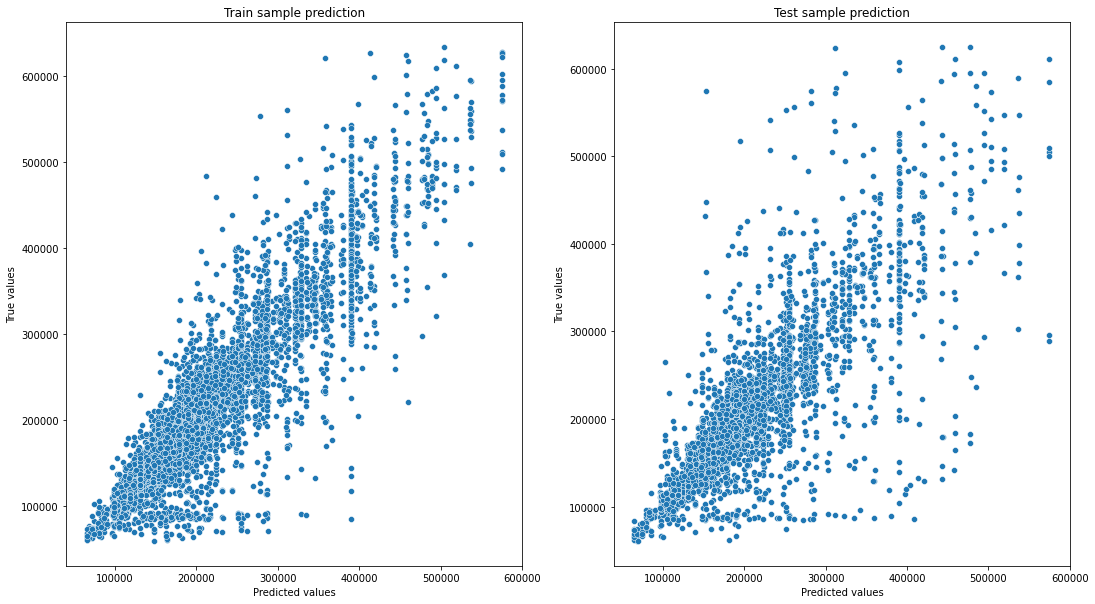

In [9]:
y_train_preds = tree.predict(X_train)
y_test_preds = tree.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

*Изи R2 > 0.6 почти мгновенно. 
Но это не интересно, пойду дальше по пунктам.*

### 1. Приведение типов, EDA  

##### Приведение типов

In [10]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

У нас есть ID и DistrictId - признаки с типом int, но их сравнение не даёт никакой полезной информации. Было бы странно, если их сравнение (больше - меньше) влияло бы на модель.
Приведу их к str, а ID вообще потом выкину.

In [11]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

###### EDA

Целевая переменная

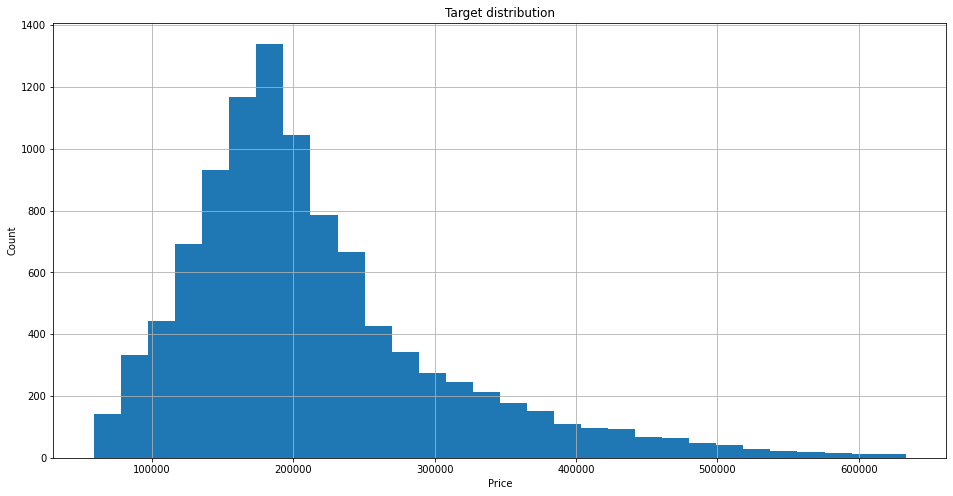

In [12]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

Количественные переменные

In [13]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Сначала разберусь с признаком Healthcare_1. Попробую найти связь с другим признаком, Healthcare_2, а также посмотрю на его распределение

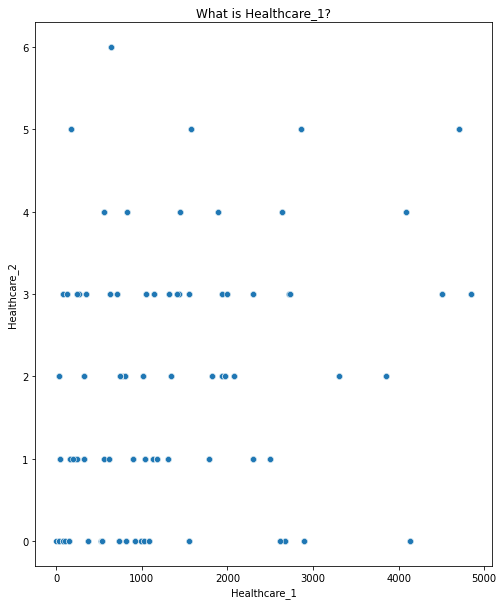

In [15]:
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_df[~train_df['Healthcare_1'].isna()]['Healthcare_1'], y=train_df[~train_df['Healthcare_1'].isna()]['Helthcare_2'])
    plt.xlabel('Healthcare_1')
    plt.ylabel('Healthcare_2')
    plt.title('What is Healthcare_1?')
    plt.plot();

*Пока непонятно.*

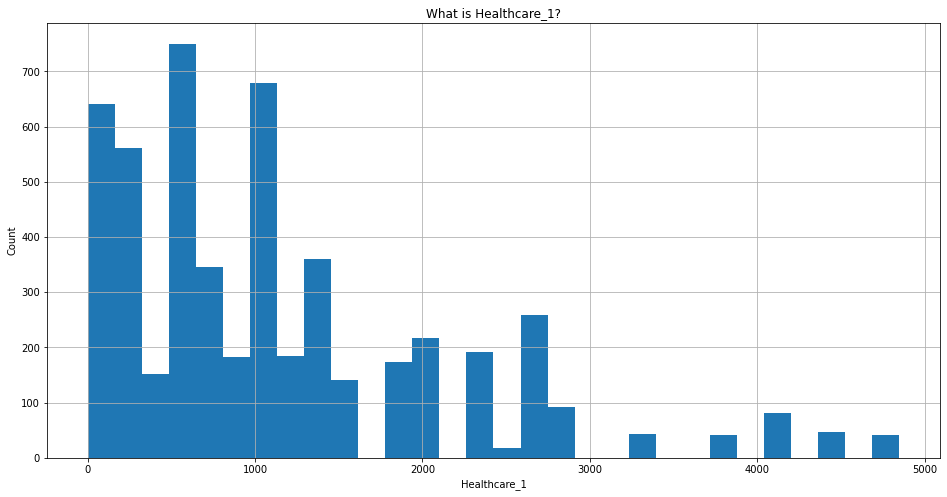

In [16]:
plt.figure(figsize = (16, 8))

train_df[~train_df['Healthcare_1'].isna()]['Healthcare_1'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Healthcare_1')

plt.title('What is Healthcare_1?')
plt.show()

*И всё еще непонятно. Может, какая-то мера расстояния?*

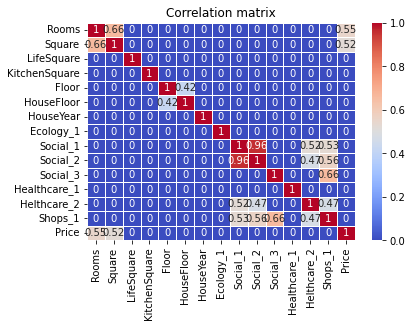

In [17]:
corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Вывод - признак Healthcare_1 линейно независим от других признаков. Придётся менять пропуски на медиану.

Вот какие ещё значения буду исключать/заменять в обработке данных:
* Rooms - меньше 1 или больше 7
* Пропуски LifeSquare - посчитаю как (Square - KitchenSquare)*0.9
* KitchenSquare - меньше 3 и больше 0.975 квантиля
* Floor - меньше 1 и больше HouseFloor
* HouseFloor - меньше 1 и больше 90
* HouseYear - больше текущего года


Номинативные переменные

In [18]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [19]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
117      1
207      1
209      1
174      1
Name: DistrictId, Length: 205, dtype: int64

In [20]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [21]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [22]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

Вот какие значения буду заменять в обработке данных:

* DistrictId - сделаю частотное кодирование  
* Ecology_2, Ecology_3, Shops_2 - сделаю бинарными


Ещё можно поглядеть, как выглядят распределения признаков:

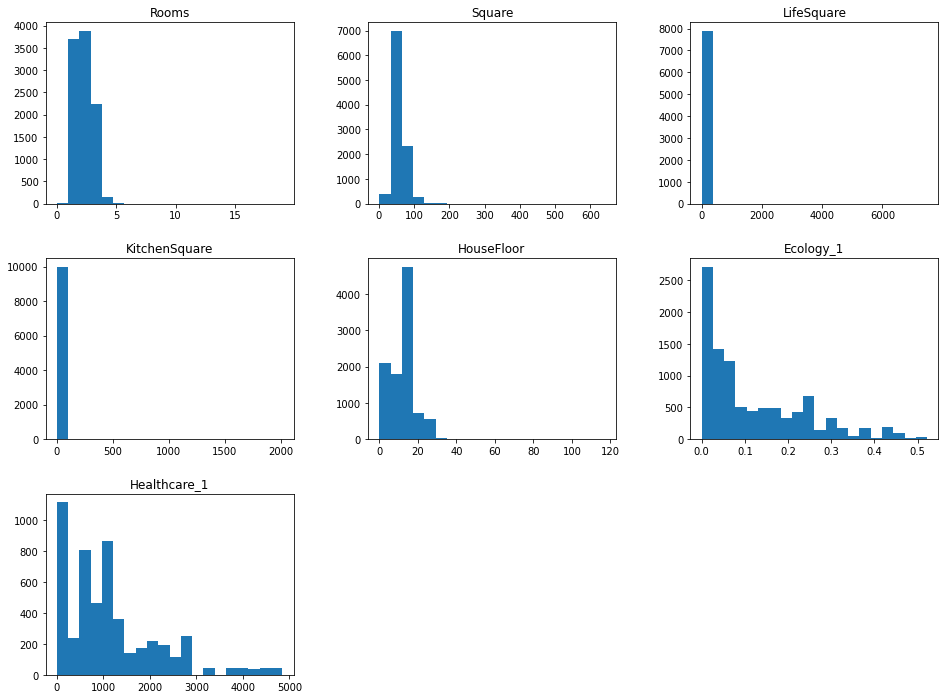

In [23]:
df_num_features = train_df.select_dtypes(include=['float64', 'float32', 'float16'])
df_num_features.drop('Price', axis=1, inplace=True)
df_num_features.hist(figsize=(16,12), bins=20, grid=False);

Осталось это реализовать с помощью класса DataPreprocessing.

### 2. Обработка данных

In [24]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        self.districts_healthcare = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # Square
        X['Square'], X['LifeSquare'] = np.where(X['Square'] < X['LifeSquare'], \
                                                  (X['LifeSquare'],X['Square']), (X['Square'],X['LifeSquare']))
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        self.districts_healthcare = X.groupby(['DistrictId'])['Healthcare_1'].agg('mean').to_dict()
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1'] = X['DistrictId'].map(self.districts_healthcare)
        X['Healthcare_1'].fillna(self.medians.Healthcare_1, inplace=True)       
        q_max = np.quantile(X['Healthcare_1'], q=0.9)
        X['Healthcare_1'].clip(upper=q_max, axis=0, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = (X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'])*0.9
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

### 3. Генерация новых фичей

Реализация будет в виде класса. Внутри сделаю:
* Бинарное кодирование признаков Ecology_2, Ecology_3, Shops_2
* Частотное кодирование DistrictID
* Таргет-энкодинг через этаж и год постройки дома. Для этого нужно будет перевести эти признаки из количественных в категориальные


In [25]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.house_year_min = None
        self.floor_min = None
        self.district_size = None
        self.districts_median_year = None
        self.districts_density = None
        self.district_price_per_square = None
        self.min_sq = None
        self.max_sq = None
        self.binary_to_numbers = {'A': 0.0, 'B': 1.0}
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Square
        self.min_sq = np.quantile(X['Square'], q=0.005)
        self.max_sq = np.quantile(X['Square'], q=0.995)      
                
        # Target encoding
        df = X.copy()
   
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.floor_min = df['Floor'].min()
            self.house_year_max = df['HouseYear'].max()
            self.house_year_min = df['HouseYear'].min()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        
        ## district price per square
        self.district_price_per_square = df.groupby(['DistrictId'])['Price'].agg('median') \
        / df.groupby(['DistrictId'])['Square'].agg('median')
        
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
    def transform(self, X):
        
        # Square
        X.loc[X['Square'] < self.min_sq, 'Square'] = self.min_sq
        X.loc[X['Square'] > self.max_sq, 'Square'] = self.max_sq
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Social
        scaler = RobustScaler()
        pca = PCA(n_components=1, random_state=42)
        social_scaled = pd.DataFrame(scaler.fit_transform(X[['Social_1', 'Social_2', 'Social_3']]))
        X['Social'] = pca.fit_transform(social_scaled)
        
        # Target encoding
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        if self.district_price_per_square is not None:
            self.district_price_per_square.to_dict()
            X['DistrictPrice'] = X['DistrictId'].map(self.district_price_per_square)
            self.median_district_price_per_square = X['DistrictPrice'].median()
            X['DistrictPrice'].fillna(self.median_district_price_per_square, inplace=True)
        return X
        

    
    
    def floor_to_cat(self, X):
        bins = [self.floor_min, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True)
        return X
     
    def year_to_cat(self, X):
        bins = [self.house_year_min, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

### 4. Разбиение на train и test. Итоговая подготовка данных

In [26]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)


In [27]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'new_district', 'MedPriceByFloorYear', 'Social', 'DistrictPrice']

target_name = 'Price'

In [28]:
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [29]:
X

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B


In [30]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=69)

In [31]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((8500, 23), (1500, 23), (5000, 23))

In [32]:
X_train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan
5613,11515,47,2.0,62.706605,37.098963,10.0,20,22.0,2007,0.197368,...,2423,1,32.0,0,1,B,0,0,0,0
6706,15570,63,2.0,35.494785,22.078078,6.0,3,9.0,1966,0.238617,...,3889,6,705.0,3,6,B,0,0,0,0
1395,887,69,3.0,75.805547,45.895949,10.0,14,17.0,1986,0.000991,...,6783,3,2300.0,1,9,B,0,0,0,0
6148,3911,38,1.0,98.412646,97.201092,3.0,1,1.0,1977,0.060753,...,2787,2,520.0,0,7,B,0,1,0,0
1752,3899,147,3.0,66.069700,50.898862,7.0,4,12.0,1996,0.319809,...,4756,16,2300.0,5,8,B,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4374,12503,6,2.0,74.273400,5.615401,3.0,1,1.0,1977,0.243205,...,1564,0,540.0,0,0,B,0,1,0,0
8631,11622,55,3.0,78.131772,47.502191,10.0,3,17.0,1989,0.041365,...,5569,0,2078.0,1,4,B,0,0,0,0
9818,16671,8,3.0,80.636765,48.143543,10.0,6,14.0,2009,0.437885,...,5735,3,1084.0,0,5,B,0,0,0,0
4041,11050,20,3.0,77.495023,46.720821,10.0,12,17.0,1993,0.019509,...,7687,11,176.0,5,5,B,0,0,0,0


In [33]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((8500, 30), (1500, 30), (5000, 30))

In [34]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [35]:
X_train

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Shops_2,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,new_district,MedPriceByFloorYear,Social,DistrictPrice
0,2.0,62.706605,37.098963,10.0,20,22.0,2007,0.197368,1.0,1.0,...,1.0,0,0,0,0,78,0,236097.181405,-1.395388,4123.023054
1,2.0,35.494785,22.078078,6.0,3,9.0,1966,0.238617,1.0,1.0,...,1.0,0,0,0,0,37,0,181020.120527,-0.390439,5388.100841
2,3.0,75.805547,45.895949,10.0,14,17.0,1986,0.000991,1.0,1.0,...,1.0,0,0,0,0,27,0,235998.207744,-0.983770,5107.131716
3,1.0,98.412646,97.201092,3.0,1,1.0,1977,0.060753,1.0,1.0,...,1.0,0,1,0,0,28,0,178848.466921,-1.193865,5165.596544
4,3.0,66.069700,50.898862,7.0,4,12.0,1996,0.319809,1.0,1.0,...,1.0,0,0,0,0,13,0,213642.888847,1.611049,5419.581950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8495,2.0,74.273400,5.615401,3.0,1,1.0,1977,0.243205,1.0,1.0,...,1.0,0,1,0,0,445,0,178848.466921,-1.597446,2783.642567
8496,3.0,78.131772,47.502191,10.0,3,17.0,1989,0.041365,1.0,1.0,...,1.0,0,0,0,0,47,0,207856.713420,-1.586400,3710.317689
8497,3.0,80.636765,48.143543,10.0,6,14.0,2009,0.437885,1.0,1.0,...,1.0,0,0,0,0,126,0,235471.652457,-0.987028,4045.875076
8498,3.0,77.495023,46.720821,10.0,12,17.0,1993,0.019509,1.0,1.0,...,1.0,0,0,0,0,21,0,235998.207744,0.618396,5566.183497


In [36]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

*Прекрасно, данные готовы, можно обучать модели!*

### 5. Построение моделей

Я обучил Random Forest и Gradient Boosting, получил следующие метрики:  
Поскольку после этого я полез в классы data_preprocessing и feature_generator, решил зафиксировать достигнутые "успехи"  
**Random Forest -**   
Train R2:	0.964  
Test R2:	0.72  

**Gradient Boosting -**  
Train R2:	0.873  
Test R2:	0.72  

*Метрики получились как у хлебушка, работаю дальше.*

На этом этапе я понял 3 вещи:

* r2 больше 0.8 может и не получиться
* кажется, проблема с обработкой данных и с генерацией фич, а не с моделями
* мой выбор - Gradient Boosting (меньше переобучается)

Идеи для улучшения классов (реализовал):
* Пропуски в признаке Healthcare_1 заменить не на медиану, а на медиану по району. Скорее всего, это мера расстояния, поэтому будет логично
* Поскольку самый важный признак - Square, обработать случаи, когда LifeSquare > Square. Обработать выбросы Square.
* Сгенерить нормальные крутые признаки:
    + медианная цена за м2 по району - такой себе таргет энкодинг, но завуалированный, поэтому модель не должна на нём переобучиться
    + сгруппировать признаки Social1..3 в новый признак

*Штош, попробую еще один boosting, но с новыми, более круто обработанными данными. Грид сёрч, как и случайный лес, остался за кадром*

###### Gradient Boosting

Train R2:	0.908
Test R2:	0.757


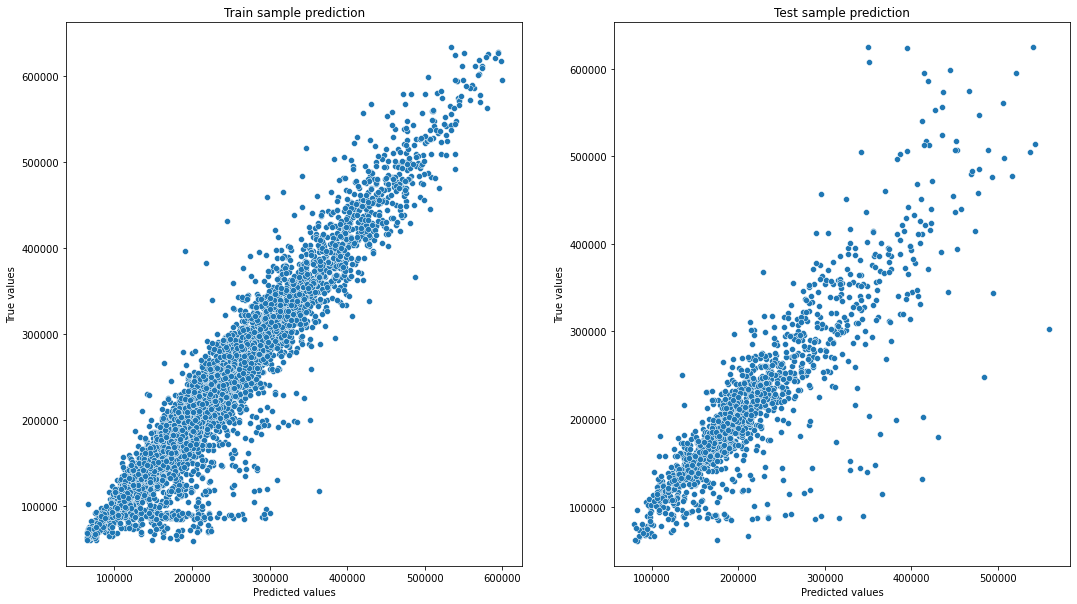

In [37]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=6,
                                     min_samples_leaf=50,
                                     random_state=69,  
                                     n_estimators=2500, 
                                     max_features='sqrt',
                                     learning_rate=0.025)
gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
y_valid_preds = gb_model.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

*Хотел 0.8 конечно, но 0.76 тоже нормально, учиывая, что идеи кончились.*

###### Важность признаков

In [38]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True);

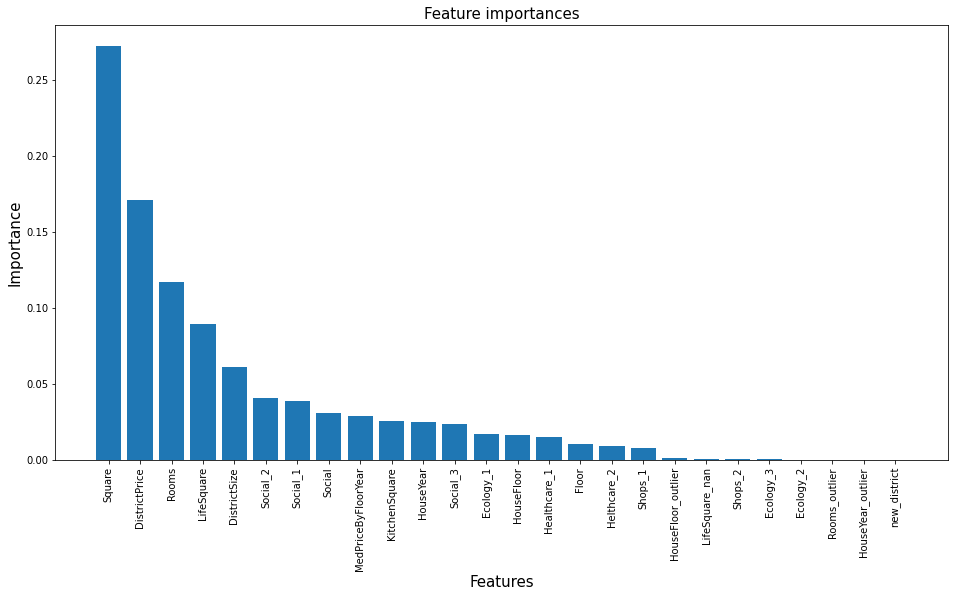

In [39]:
plt.figure(figsize = (16, 8))
plt.bar(feature_importances['feature_name'], feature_importances['importance'])
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Importance', fontsize=15)
plt.title('Feature importances', fontsize=15)
plt.show()

### 6. Прогнозирование на тестовом датасете

In [40]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Shops_2,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,new_district,MedPriceByFloorYear,Social,DistrictPrice
0,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1.0,1.0,...,1.0,0,0,0,0,90.0,0,188002.472345,-1.654285,4331.542605
1,1.0,42.568133,42.493907,10.0,7,17.0,2017,0.072158,1.0,1.0,...,0.0,0,0,0,0,208.0,0,178334.075428,-1.462656,2733.282513
2,2.0,59.463678,45.417310,9.0,19,19.0,1977,0.211401,1.0,1.0,...,1.0,0,0,0,1,742.0,0,176650.441622,-1.659865,2670.049181
3,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,1.0,1.0,...,1.0,0,0,0,0,477.0,0,181020.120527,-1.662911,2097.318683
4,1.0,53.837056,45.753350,3.0,8,17.0,1977,0.309479,1.0,1.0,...,1.0,0,0,0,1,90.0,0,192572.220319,-0.847631,3472.278624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,5,5.0,1962,0.069660,1.0,1.0,...,1.0,0,1,0,0,79.0,0,188002.472345,-0.850724,4191.151538
4996,3.0,94.521465,93.698122,10.0,21,27.0,2018,0.060753,1.0,1.0,...,1.0,0,0,0,0,28.0,0,210647.751824,-1.257825,5165.596544
4997,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,1.0,1.0,...,1.0,0,0,0,0,82.0,0,181020.120527,-1.450241,4099.952329
4998,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,1.0,1.0,...,1.0,0,0,0,0,51.0,0,192572.220319,-0.647366,4347.926191


In [46]:
submit = pd.read_csv('sample_submission.csv')
predictions = gb_model.predict(test_df)
submit['Price'] = predictions
submit.to_csv('gb_submit.csv', index=False)